In [7]:
# importeer packages
import pandas as pd
import lifelines
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
psych = pd.read_csv('psych.csv')

In [4]:
psych

,id,age,main_hobby,ad_topic,device_type,screen_brightness,skip_time,skipped?
0,1,20,fashion,sports,tablet,68,15,yes
1,2,24,fashion,fashion,desktop,65,103,NaN
2,3,23,sports,fashion,desktop,77,26,yes
3,4,19,fashion,gaming,desktop,88,8,yes
4,5,23,sports,sports,desktop,71,122,yes
...,...,...,...,...,...,...,...,...
415,416,21,fashion,gaming,desktop,72,39,yes
416,417,25,sports,sports,desktop,71,22,yes
417,418,21,sports,sports,desktop,78,56,yes
418,419,18,sports,gaming,tablet,62,22,yes


In [5]:
psych['main_hobby'].unique()

array(['fashion', 'sports', 'gaming'], dtype=object)

Voor event geldt:
- 1: Event heeft plaatsgevonden na survival time
- 0: Deelnemer heeft hele advertentie uitgekeken
- NaN: Meetfout tijdens experiment 

In [20]:

psych_ibs = pd.DataFrame()

psych_ibs['Hobby'] = psych['main_hobby'].map({'fashion': 0, 'sports': 1, 'gaming': 2})
psych_ibs['Topic'] = psych['ad_topic'].map({'fashion': 0, 'sports': 1, 'gaming': 2})
psych_ibs['Device'] = psych['device_type'].map({'tablet': 0, 'desktop': 1, 'laptop': 2})
psych_ibs['Brightness'] = psych['screen_brightness']
psych_ibs['Leeftijd'] = psych['age']
psych_ibs['Survival_time'] = psych['skip_time']
psych_ibs["Event"] = psych["skipped?"].map({'yes': 1, 'no': 0})
psych_ibs["Event"] = psych_ibs["Event"].fillna(0) # Meetfouten ook op 0 zetten, geen event waargenomen
psych_ibs['Censoring'] = 1 - psych_ibs["Event"]

psych_ibs 

,Hobby,Topic,Device,Brightness,Leeftijd,Survival_time,Event,Censoring
0,0,1,0,68,20,15,1.0,0.0
1,0,0,1,65,24,103,0.0,1.0
2,1,0,1,77,23,26,1.0,0.0
3,0,2,1,88,19,8,1.0,0.0
4,1,1,1,71,23,122,1.0,0.0
...,...,...,...,...,...,...,...,...
415,0,2,1,72,21,39,1.0,0.0
416,1,1,1,71,25,22,1.0,0.0
417,1,1,1,78,21,56,1.0,0.0
418,1,2,0,62,18,22,1.0,0.0


We gaan een CPH-model (Cox Proportional Hazards model) fitten met behulp van de CoxPHFitter binnen lifelines. Eerst kijken we naar alle mogelijke beschikbare covariaten.

We streven naar een zo'n hoog mogelijke Concordance Index, in de realiteit is een index tussen 0.55 en 0.75 een goed streefpunt.

_(Op basis van dit model zal gekeken worden welke factoren statistische significantie aantonen)_
Wij nemen hierbij aan $\alpha = 0.05$

AIC meet hoe goed een model de data past, rekening houdend met het aantal parameters (complexiteit) Hoe lager hoe beter!


In [21]:
# roep CoxPH-fitter aan
cph = lifelines.CoxPHFitter()
# fit een CPH-model 
cph.fit(psych_ibs, duration_col='Survival_time', event_col='Event', formula='Hobby+Topic+Device+Brightness+Leeftijd')

<lifelines.CoxPHFitter: fitted with 420 total observations, 41 right-censored observations>

In [22]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 420 total observations, 41 right-censored observations>
             duration col = 'Survival_time'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 420
number of events observed = 379
   partial log-likelihood = -1906.78
         time fit was run = 2025-11-21 08:39:39 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
Hobby       -0.15       0.86       0.09            -0.32             0.03                 0.73                 1.03
Topic        0.34       1.40       0.08             0.19             0.49                 1.21                 1.63
Device       0.05       1.05       0.07            -0.09             0.18                 0.92                 1.20
Brightness   0.01       1.01       0.01            -0.01             0.02                 0.99                 1.02
Leeftijd    -0.02       0.98       0.03            -0.07             0.03                 0.93                 1.03

             cmp to     z      p   -log2(p)
covariate                                  
Hobby          0.00 -1.67   0.10       3.38
Topic          0.00  4.39 <0.005      16.43
Device         0.00  0.69   0.49       1.04
Brightness     0.00  0.91   0.36       1.47
Leeftijd       0.00 -0.73   0.46       1.11
---
Concordance = 0.57
Partial AIC = 3823.57
log-likelihood ratio test = 21.22 on 5 df
-log2(p) of ll-ratio test = 10.41


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 420 total observations, 41 right-censored observations>
         test_name = proportional_hazard_test

---
                 test_statistic    p  -log2(p)
Brightness km              0.03 0.85      0.23
           rank            0.03 0.87      0.21
Device     km              1.69 0.19      2.37
           rank            1.83 0.18      2.50
Hobby      km              0.21 0.65      0.62
           rank            0.27 0.61      0.72
Leeftijd   km              3.68 0.05      4.19
           rank            3.70 0.05      4.20
Topic      km              0.10 0.75      0.42
           rank            0.12 0.73      0.46



1. Variable 'Leeftijd' failed the non-proportional test: p-value is 0.0543.

   Advice 1: the functional form of the variable 'Leeftijd' might be incorrect. That is, there may
be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Leeftijd' using pd.cut, and then specify it in
`strata=['Leeftijd', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#

[[<Axes: xlabel='rank-transformed time\n(p=0.6062)'>,
  <Axes: xlabel='km-transformed time\n(p=0.6496)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.7274)'>,
  <Axes: xlabel='km-transformed time\n(p=0.7495)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1765)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1930)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.8672)'>,
  <Axes: xlabel='km-transformed time\n(p=0.8548)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0543)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0549)'>]]

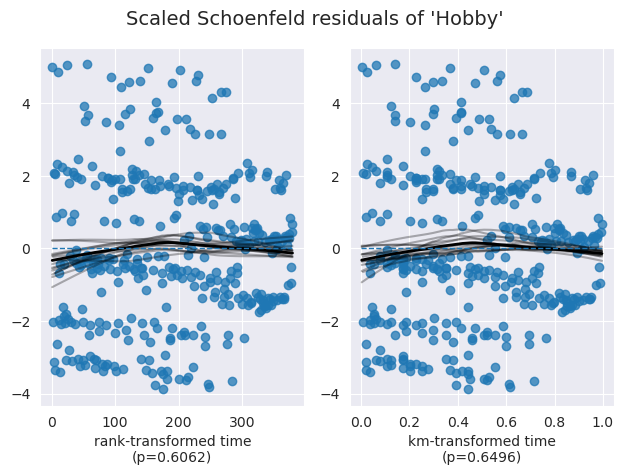

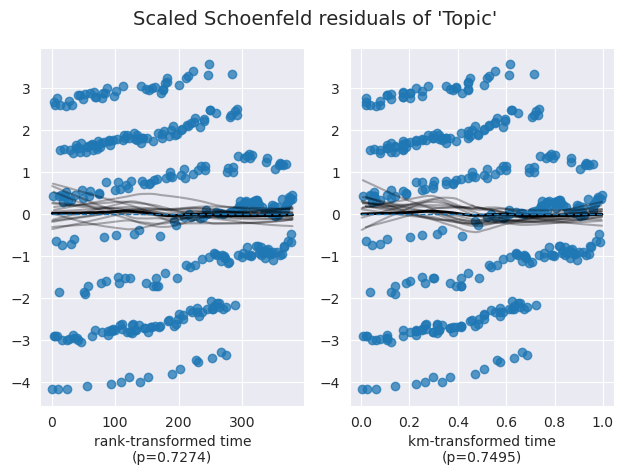

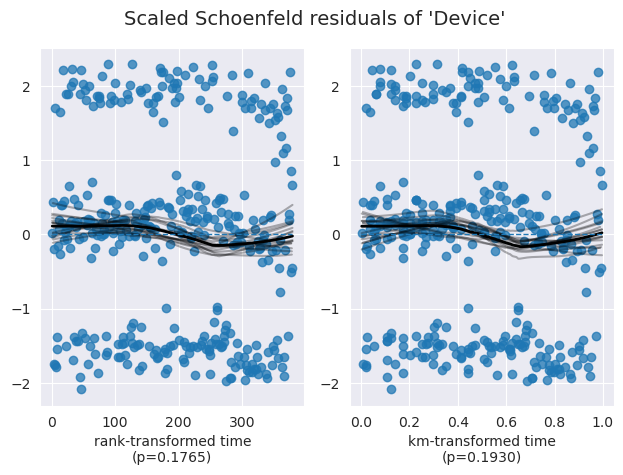

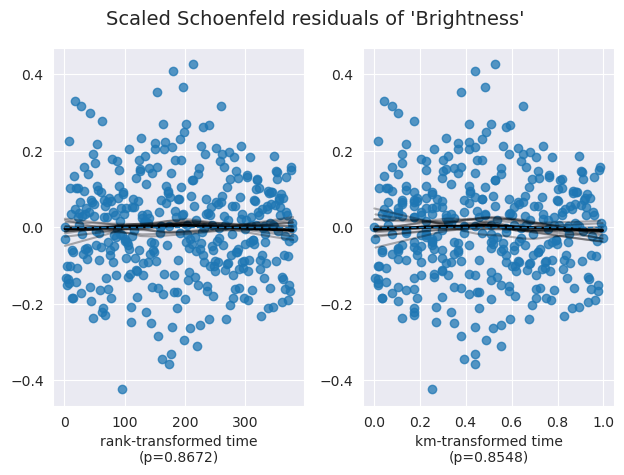

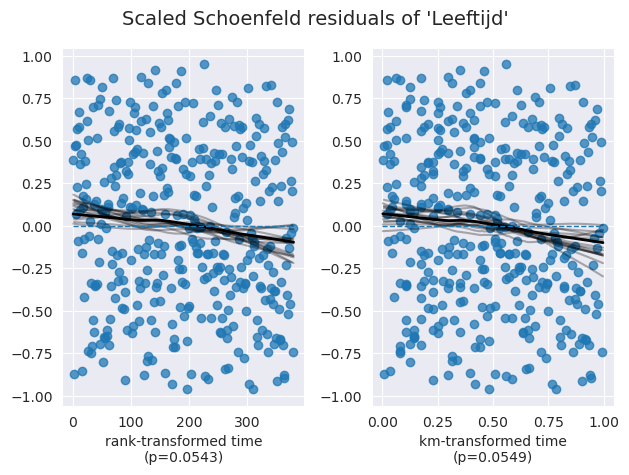

In [32]:
cph.check_assumptions(psych_ibs, p_value_threshold=0.05, show_plots=True)

Dit model haalt een Concordance Index van `0.57` en een Partial AIC van `3823.57`. We streven erna om de Concordance Index verder te verhogen en de AIC verder te verlagen in een nieuw model.

We zien dat de p-value van `Topic` de enige is die kleiner is dan $\alpha = 0.05$, dit is dus de enige factor die wel statistisch significant is. De overige factoren halen we eruit?


_(Uitleggen hoe je zo'n summary leest?)_

In [26]:
# roep CoxPH-fitter aan
cph2 = lifelines.CoxPHFitter()
# fit een CPH-model 
cph2.fit(psych_ibs, duration_col='Survival_time', event_col='Event', formula='Topic')

cph2.print_summary()

<lifelines.CoxPHFitter: fitted with 420 total observations, 41 right-censored observations>
             duration col = 'Survival_time'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 420
number of events observed = 379
   partial log-likelihood = -1909.04
         time fit was run = 2025-11-21 09:07:16 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Topic       0.28       1.32       0.07             0.15             0.41                 1.16                 1.51

            cmp to    z      p   -log2(p)
covariate                                
Topic         0.00 4.09 <0.005      14.49
---
Concordance = 0.56
Partial AIC = 3820.07
log-likelihood ratio test = 16.71 on 1 df
-log2(p) of ll-ratio test = 14.49

We zien in dit versimpelde model een Concordance Index afgenomen is met `0.01` van `0.57` naar `0.56`. Verder is de Partial AIC afgenomen van `3823` naar `3820`

De AIC is met 2 punten afgenomen wat aangeeft dat ondanks de vereenvoudiging dit nieuwe model de data nog steeds goed vastlegt, vooral gezien we van 5 naar 1 covariaten zijn gegaan.

De daling van `0.01` punten in de C-Index is een minimale daling en valt nog steeds binnen de gewenste range van `0.55-0.75`


als topic stijgt met 1, neemt kans dat iemand wegklikt toe met 1.32
dus als we de volgorde van de topics veranderen veranderd de coefficient?
sanjaaay!



   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


[[<Axes: xlabel='rank-transformed time\n(p=0.3432)'>,
  <Axes: xlabel='km-transformed time\n(p=0.3470)'>]]

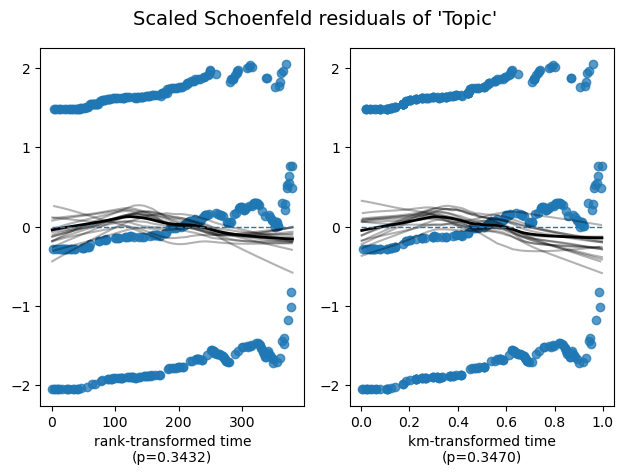

In [28]:
cph2.check_assumptions(psych_ibs, p_value_threshold=0.05, show_plots=True)

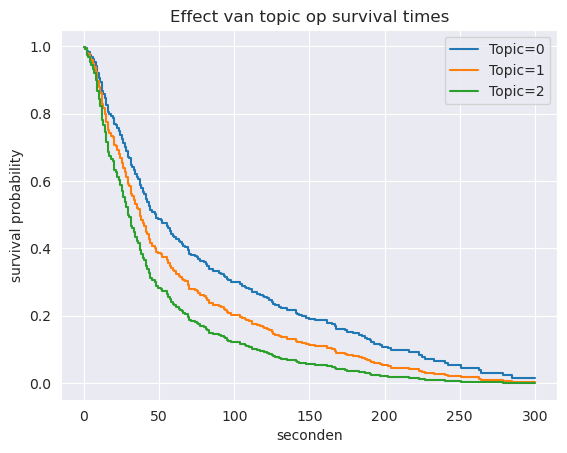

In [31]:
sns.set_style('darkgrid')
cph2.plot_partial_effects_on_outcome(covariates = ['Topic'], values = ['0', '1', '2'], plot_baseline = False)
plt.xlabel('seconden')
plt.ylabel('survival probability')
plt.title('Effect van topic op survival times')
plt.show()